In [13]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.dataset import HangmanDataset
import numpy as np
import pickle
import random
from tqdm import tqdm


vocab =  [chr(i) for i in range(97, 123)] + ['<SOS>', '<MASK>', '<PAD>']
vocab_size = len(vocab)
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}


# Set the seed for reproducibility
SEED = 42
random.seed(SEED)

# Read and clean words
with open('words_250000_train.txt', 'r') as file:
    training_words = [line.strip().lower() for line in file if line.strip().isalpha()]

# Group words by their lengths
word_dict_by_len = {}
for word in tqdm(training_words):
    l = len(word)
    word_dict_by_len.setdefault(l, []).append(word)

100%|████████████████████████████████████████████████████████████| 227300/227300 [00:00<00:00, 1477632.14it/s]


In [62]:
import torch
import numpy as np
import random

def play_random_batch(batch_words, stoi, itos, max_trials=26):
    batch_size = len(batch_words)
    
    word_lengths = [len(w) for w in batch_words]
    max_len = max(word_lengths)
    vocab = [ch for ch in list(stoi.keys()) if ch not in ['<PAD>', '<SOS>', '<MASK>']]

    target_chars = [list(w) for w in batch_words]
    revealed = [['<MASK>'] * l for l in word_lengths]

    # Metrics
    incorrect_guesses = torch.zeros(batch_size, dtype=torch.int32)
    trials = torch.zeros(batch_size, dtype=torch.int32)
    word_won = torch.zeros(batch_size, dtype=torch.bool)
    duplicate_counts = torch.zeros(batch_size, dtype=torch.int32)
    guessed_history = [[] for _ in range(batch_size)]

    for step in range(max_trials):
        for b in range(batch_size):
            if word_won[b]:
                continue
            trials[b] += 1

            # Sample a random character not guessed yet
            remaining_choices = list(set(vocab) - set(guessed_history[b]))
            if not remaining_choices:
                continue  # all guessed
            pred_char = random.choice(remaining_choices)
            guessed_history[b].append(pred_char)

            if pred_char in target_chars[b]:
                for i, ch in enumerate(target_chars[b]):
                    if ch == pred_char:
                        revealed[b][i] = pred_char
                if revealed[b] == target_chars[b] and incorrect_guesses[b] < 6:
                    word_won[b] = True
            else:
                incorrect_guesses[b] += 1

            # Count duplicates (not likely but just in case)
            if guessed_history[b].count(pred_char) > 1:
                duplicate_counts[b] += 1

        if word_won.all():
            break

    return incorrect_guesses.tolist(), word_won.tolist(), duplicate_counts.tolist()



In [89]:
# total_wins = 0
# for word_length, word_list in word_dict_by_len.items():
#     print(f'word length of {word_length}')



from tqdm import tqdm
result_dict = dict()
total_wins = 0
for word_length, word_list in word_dict_by_len.items():
    print(f'word length of {word_length}')

    random.shuffle(word_list)
    split_idx = int(0.7 * len(word_list))
#     test_dataset = HangmanDataset(word_list, max_word_length=word_length, max_guesses=26)
    dataloader = DataLoader(
            word_list[split_idx:],
            batch_size=16,
            num_workers=4,
        )
    incorrects_all = []
    wins = 0
    
    for batch_words in tqdm(dataloader):  # Replace with your loader
        inc, won, dups = play_random_batch(batch_words, stoi, itos)
#         print(inc)
        incorrects_all.extend(inc)
        wins += sum(won)
    
    result_dict[word_length] = incorrects_all
    print(f"Random Baseline:")
    print(f"  Accuracy: {wins}/{len(incorrects_all)} = {wins/len(incorrects_all):.2%}")
    print(f"  Avg Incorrect Guesses: {np.mean(incorrects_all):.2f}")
    total_wins += wins

print(total_wins)

word length of 3


100%|█████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 73.11it/s]


Random Baseline:
  Accuracy: 27/661 = 4.08%
  Avg Incorrect Guesses: 22.33
word length of 6


100%|███████████████████████████████████████████████████████████████████████| 367/367 [00:04<00:00, 90.38it/s]


Random Baseline:
  Accuracy: 38/5863 = 0.65%
  Avg Incorrect Guesses: 20.58
word length of 4


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.76it/s]


Random Baseline:
  Accuracy: 34/1587 = 2.14%
  Avg Incorrect Guesses: 21.87
word length of 5


100%|███████████████████████████████████████████████████████████████████████| 212/212 [00:02<00:00, 91.35it/s]


Random Baseline:
  Accuracy: 34/3383 = 1.01%
  Avg Incorrect Guesses: 21.25
word length of 8


100%|███████████████████████████████████████████████████████████████████████| 571/571 [00:06<00:00, 94.88it/s]


Random Baseline:
  Accuracy: 31/9136 = 0.34%
  Avg Incorrect Guesses: 19.23
word length of 7


100%|███████████████████████████████████████████████████████████████████████| 487/487 [00:05<00:00, 90.06it/s]


Random Baseline:
  Accuracy: 39/7785 = 0.50%
  Avg Incorrect Guesses: 19.86
word length of 10


100%|███████████████████████████████████████████████████████████████████████| 506/506 [00:05<00:00, 93.78it/s]


Random Baseline:
  Accuracy: 24/8086 = 0.30%
  Avg Incorrect Guesses: 17.98
word length of 9


100%|███████████████████████████████████████████████████████████████████████| 580/580 [00:05<00:00, 97.85it/s]


Random Baseline:
  Accuracy: 20/9272 = 0.22%
  Avg Incorrect Guesses: 18.58
word length of 11


100%|███████████████████████████████████████████████████████████████████████| 428/428 [00:04<00:00, 95.19it/s]


Random Baseline:
  Accuracy: 15/6836 = 0.22%
  Avg Incorrect Guesses: 17.43
word length of 12


100%|███████████████████████████████████████████████████████████████████████| 341/341 [00:03<00:00, 95.93it/s]


Random Baseline:
  Accuracy: 11/5454 = 0.20%
  Avg Incorrect Guesses: 16.93
word length of 13


100%|███████████████████████████████████████████████████████████████████████| 243/243 [00:02<00:00, 93.51it/s]


Random Baseline:
  Accuracy: 6/3887 = 0.15%
  Avg Incorrect Guesses: 16.50
word length of 15


100%|█████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 89.61it/s]


Random Baseline:
  Accuracy: 6/1564 = 0.38%
  Avg Incorrect Guesses: 15.69
word length of 14


100%|███████████████████████████████████████████████████████████████████████| 164/164 [00:01<00:00, 92.73it/s]


Random Baseline:
  Accuracy: 4/2613 = 0.15%
  Avg Incorrect Guesses: 16.11
word length of 20


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.05it/s]


Random Baseline:
  Accuracy: 0/68 = 0.00%
  Avg Incorrect Guesses: 13.93
word length of 17


100%|█████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 76.72it/s]


Random Baseline:
  Accuracy: 1/533 = 0.19%
  Avg Incorrect Guesses: 15.05
word length of 16


100%|█████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 69.19it/s]


Random Baseline:
  Accuracy: 2/943 = 0.21%
  Avg Incorrect Guesses: 15.43
word length of 2


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.38it/s]


Random Baseline:
  Accuracy: 9/80 = 11.25%
  Avg Incorrect Guesses: 21.82
word length of 21


100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.90it/s]


Random Baseline:
  Accuracy: 0/30 = 0.00%
  Avg Incorrect Guesses: 13.73
word length of 18


100%|█████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 59.29it/s]


Random Baseline:
  Accuracy: 0/258 = 0.00%
  Avg Incorrect Guesses: 14.72
word length of 19


100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 44.61it/s]


Random Baseline:
  Accuracy: 0/133 = 0.00%
  Avg Incorrect Guesses: 14.57
word length of 25


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]


Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 13.00
word length of 22


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Random Baseline:
  Accuracy: 0/14 = 0.00%
  Avg Incorrect Guesses: 13.14
word length of 1


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


Random Baseline:
  Accuracy: 2/6 = 33.33%
  Avg Incorrect Guesses: 17.33
word length of 23


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


Random Baseline:
  Accuracy: 0/5 = 0.00%
  Avg Incorrect Guesses: 13.40
word length of 29


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 14.00
word length of 24


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.32it/s]


Random Baseline:
  Accuracy: 0/3 = 0.00%
  Avg Incorrect Guesses: 12.67
word length of 28


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.57it/s]


Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 13.00
word length of 27


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]

Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 14.00
303


In [74]:
293/68204

0.42959357222450295

In [90]:
print(total_wins)
with open(f'randomAgentResults.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

303


With Random won only 0.4% of the time

In [70]:


import torch
import numpy as np
import random
from collections import Counter


subsampled_words_dict = dict()

for length, word_list in word_dict_by_len.items():
    random.shuffle(word_list)
    split_idx = int(0.7 * len(word_list))
    subsampled_words_dict[length] = word_list[:split_idx]

    
def play_frequency_informed_batch(batch_words, stoi, itos, max_trials=26, min_pool_size=2):
    batch_size = len(batch_words)
    word_length = len(batch_words[0])
    assert all(len(w) == word_length for w in batch_words)

    vocab = [ch for ch in stoi if ch not in ['<PAD>', '<SOS>', '<MASK>']]
    target_chars = [list(w) for w in batch_words]
    revealed = [['<MASK>'] * word_length for _ in range(batch_size)]

    incorrect_guesses = torch.zeros(batch_size, dtype=torch.int32)
    trials = torch.zeros(batch_size, dtype=torch.int32)
    word_won = torch.zeros(batch_size, dtype=torch.bool)
    duplicate_counts = torch.zeros(batch_size, dtype=torch.int32)
    guessed_history = [[] for _ in range(batch_size)]

    subsampled_words = subsampled_words_dict[word_length]

    for step in range(max_trials):
        for b in range(batch_size):
            if word_won[b]:
                continue

            # 1. Build masked pattern
            pattern = revealed[b]

            # 2. Filter subsample to only those matching current revealed pattern
            candidate_pool = []
            for w in subsampled_words:
                match = True
                for i in range(word_length):
                    if pattern[i] != '<MASK>' and w[i] != pattern[i]:
                        match = False
                        break
                if match:
                    candidate_pool.append(w)

            # 3. Count frequency of unguessed characters at masked positions
            guessed = guessed_history[b]
            remaining_choices = list(set(vocab) - set(guessed))
            if not remaining_choices:
                continue  # skip if everything already guessed

            if len(candidate_pool) < min_pool_size:
                pred_char = random.choice(remaining_choices)
            else:
                letter_freq = Counter()
                for w in candidate_pool:
                    for i, ch in enumerate(w):
                        if pattern[i] == '<MASK>' and ch not in guessed:
                            letter_freq[ch] += 1

                if not letter_freq:
                    pred_char = random.choice(remaining_choices)
                else:
                    pred_char = letter_freq.most_common(1)[0][0]

            # 4. Update game state
            trials[b] += 1
            if pred_char in guessed:
                duplicate_counts[b] += 1
            guessed_history[b].append(pred_char)

            if pred_char in target_chars[b]:
                for i, ch in enumerate(target_chars[b]):
                    if ch == pred_char:
                        revealed[b][i] = pred_char
                if revealed[b] == target_chars[b] and incorrect_guesses[b] < 6:
                    word_won[b] = True
            else:
                incorrect_guesses[b] += 1

        if word_won.all():
            break

    return incorrect_guesses.tolist(), word_won.tolist(), duplicate_counts.tolist()

In [93]:
from tqdm import tqdm

total_wins = 0
result_dict = dict()
for word_length, word_list in word_dict_by_len.items():
    print(f'word length of {word_length}')

    random.shuffle(word_list)
    split_idx = int(0.7 * len(word_list))
#     test_dataset = HangmanDataset(word_list, max_word_length=word_length, max_guesses=26)
    dataloader = DataLoader(
            word_list[split_idx:],
            batch_size=16,
            num_workers=4,
        )
    incorrects_all = []
    wins = 0
    
    for batch_words in tqdm(dataloader):  # Replace with your loader
        inc, won, dups = play_frequency_informed_batch(batch_words, stoi, itos)
        incorrects_all.extend(inc)
        wins += sum(won)
        
    result_dict[word_length] = incorrects_all
    print(f"Random Baseline:")
    print(f"  Accuracy: {wins}/{len(incorrects_all)} = {wins/len(incorrects_all):.2%}")
    print(f"  Avg Incorrect Guesses: {np.mean(incorrects_all):.2f}")
    print(f"  Avg Duplicates: {np.mean(dups_all):.2f}")
    total_wins += wins

print(total_wins)

word length of 3


100%|█████████████████████████████████████████████████████████████████████████| 42/42 [00:11<00:00,  3.62it/s]


Random Baseline:
  Accuracy: 152/661 = 23.00%
  Avg Incorrect Guesses: 18.75
  Avg Duplicates: 0.00
word length of 6


100%|███████████████████████████████████████████████████████████████████████| 367/367 [16:00<00:00,  2.62s/it]


Random Baseline:
  Accuracy: 641/5863 = 10.93%
  Avg Incorrect Guesses: 18.84
  Avg Duplicates: 0.00
word length of 4


100%|███████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.59it/s]


Random Baseline:
  Accuracy: 352/1587 = 22.18%
  Avg Incorrect Guesses: 18.19
  Avg Duplicates: 0.00
word length of 5


100%|███████████████████████████████████████████████████████████████████████| 212/212 [05:06<00:00,  1.45s/it]


Random Baseline:
  Accuracy: 496/3383 = 14.66%
  Avg Incorrect Guesses: 18.86
  Avg Duplicates: 0.00
word length of 8


100%|███████████████████████████████████████████████████████████████████████| 571/571 [41:12<00:00,  4.33s/it]


Random Baseline:
  Accuracy: 501/9136 = 5.48%
  Avg Incorrect Guesses: 18.45
  Avg Duplicates: 0.00
word length of 7


100%|███████████████████████████████████████████████████████████████████████| 487/487 [29:10<00:00,  3.59s/it]


Random Baseline:
  Accuracy: 627/7785 = 8.05%
  Avg Incorrect Guesses: 18.65
  Avg Duplicates: 0.00
word length of 10


100%|███████████████████████████████████████████████████████████████████████| 506/506 [33:53<00:00,  4.02s/it]


Random Baseline:
  Accuracy: 204/8086 = 2.52%
  Avg Incorrect Guesses: 17.69
  Avg Duplicates: 0.00
word length of 9


100%|███████████████████████████████████████████████████████████████████████| 580/580 [43:34<00:00,  4.51s/it]


Random Baseline:
  Accuracy: 318/9272 = 3.43%
  Avg Incorrect Guesses: 18.12
  Avg Duplicates: 0.00
word length of 11


100%|███████████████████████████████████████████████████████████████████████| 428/428 [25:05<00:00,  3.52s/it]


Random Baseline:
  Accuracy: 115/6836 = 1.68%
  Avg Incorrect Guesses: 17.25
  Avg Duplicates: 0.00
word length of 12


100%|███████████████████████████████████████████████████████████████████████| 341/341 [16:14<00:00,  2.86s/it]


Random Baseline:
  Accuracy: 93/5454 = 1.71%
  Avg Incorrect Guesses: 16.77
  Avg Duplicates: 0.00
word length of 13


100%|███████████████████████████████████████████████████████████████████████| 243/243 [08:27<00:00,  2.09s/it]


Random Baseline:
  Accuracy: 38/3887 = 0.98%
  Avg Incorrect Guesses: 16.38
  Avg Duplicates: 0.00
word length of 15


100%|█████████████████████████████████████████████████████████████████████████| 98/98 [01:23<00:00,  1.17it/s]


Random Baseline:
  Accuracy: 7/1564 = 0.45%
  Avg Incorrect Guesses: 15.70
  Avg Duplicates: 0.00
word length of 14


100%|███████████████████████████████████████████████████████████████████████| 164/164 [03:50<00:00,  1.40s/it]


Random Baseline:
  Accuracy: 27/2613 = 1.03%
  Avg Incorrect Guesses: 15.98
  Avg Duplicates: 0.00
word length of 20


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.68it/s]


Random Baseline:
  Accuracy: 0/68 = 0.00%
  Avg Incorrect Guesses: 14.22
  Avg Duplicates: 0.00
word length of 17


100%|█████████████████████████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.27it/s]


Random Baseline:
  Accuracy: 4/533 = 0.75%
  Avg Incorrect Guesses: 15.08
  Avg Duplicates: 0.00
word length of 16


100%|█████████████████████████████████████████████████████████████████████████| 59/59 [00:31<00:00,  1.86it/s]


Random Baseline:
  Accuracy: 5/943 = 0.53%
  Avg Incorrect Guesses: 15.45
  Avg Duplicates: 0.00
word length of 2


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.90it/s]


Random Baseline:
  Accuracy: 23/80 = 28.75%
  Avg Incorrect Guesses: 18.34
  Avg Duplicates: 0.00
word length of 21


100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


Random Baseline:
  Accuracy: 0/30 = 0.00%
  Avg Incorrect Guesses: 14.43
  Avg Duplicates: 0.00
word length of 18


100%|█████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.20it/s]


Random Baseline:
  Accuracy: 0/258 = 0.00%
  Avg Incorrect Guesses: 14.85
  Avg Duplicates: 0.00
word length of 19


100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.50it/s]


Random Baseline:
  Accuracy: 1/133 = 0.75%
  Avg Incorrect Guesses: 14.64
  Avg Duplicates: 0.00
word length of 25


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 14.00
  Avg Duplicates: 0.00
word length of 22


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.00it/s]


Random Baseline:
  Accuracy: 0/14 = 0.00%
  Avg Incorrect Guesses: 13.50
  Avg Duplicates: 0.00
word length of 1


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.89it/s]


Random Baseline:
  Accuracy: 1/6 = 16.67%
  Avg Incorrect Guesses: 21.67
  Avg Duplicates: 0.00
word length of 23


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.87it/s]


Random Baseline:
  Accuracy: 0/5 = 0.00%
  Avg Incorrect Guesses: 12.60
  Avg Duplicates: 0.00
word length of 29


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.67it/s]


Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 14.00
  Avg Duplicates: 0.00
word length of 24


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.13it/s]


Random Baseline:
  Accuracy: 0/3 = 0.00%
  Avg Incorrect Guesses: 13.67
  Avg Duplicates: 0.00
word length of 28


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.56it/s]


Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 13.00
  Avg Duplicates: 0.00
word length of 27


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]

Random Baseline:
  Accuracy: 0/1 = 0.00%
  Avg Incorrect Guesses: 13.00
  Avg Duplicates: 0.00
3605


In [72]:
3636/68204

0.05331065626649464

In [94]:
print(total_wins)
with open(f'frequencyInformedAgentResults.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

3605


In [95]:
import pickle

with open(f'/home/nximish/Friend_D/results.pkl', 'rb') as f:
    CanineModelResult = pickle.load(f)

with open(f'/home/nximish/HangmanProblem/test_results/resultscheckpoint.49th.pkl', 'rb') as f:
    GPTAgentResult = pickle.load(f)
    
with open(f'randomAgentResults.pkl', 'rb') as f:
    randomAgentResult = pickle.load(f)
    
with open(f'frequencyInformedAgentResults.pkl', 'rb') as f:
    frequencyInformedAgentResult = pickle.load(f)

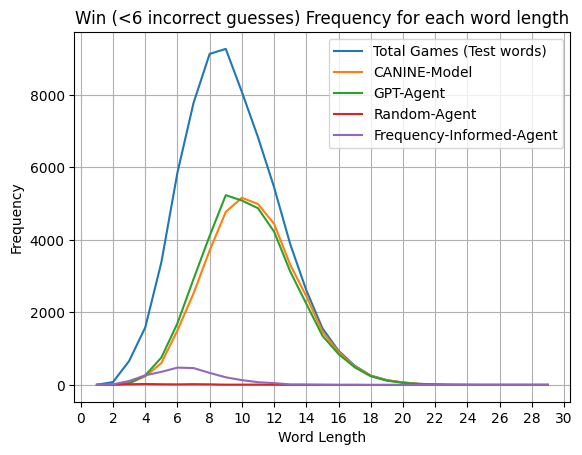

In [103]:
# for wordLen, inc_gues in loaded_data['incorrectGuessesDict'].items():
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

total_test_samples = 68204
word_lengths =  CanineModelResult.keys()
word_lengths = sorted(word_lengths)

winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = CanineModelResult[wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    totalList.append(total_words)
    winsList.append(wins)

plt.plot(word_lengths, totalList, label='Total Games (Test words)')
plt.plot(word_lengths, winsList, label='CANINE-Model')


winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = GPTAgentResult['incorrectGuessesDict'][wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    totalList.append(total_words)
    winsList.append(wins)

plt.plot(word_lengths, winsList, label='GPT-Agent')

winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = randomAgentResult[wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    totalList.append(total_words)
    winsList.append(wins)

plt.plot(word_lengths, winsList, label='Random-Agent')

winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = frequencyInformedAgentResult[wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    totalList.append(total_words)
    winsList.append(wins)

plt.plot(word_lengths, winsList, label='Frequency-Informed-Agent')


# plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.title(f"Win (<6 incorrect guesses) Frequency for each word length")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()
